#### Data extracting

First, we need to open a connection to the database file and get all the names of the tables.

In [1]:
import pandas as pd
import sqlite3

# Establish a connection to the database
conn = sqlite3.connect('publications_graph.db')

# Get a cursor object
cursor = conn.cursor()

# Execute a query to get the table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch the table names
table_names = cursor.fetchall()

# Loop over the table names and read them into pandas dataframes


# Close the cursor and the connection to the database
# cursor.close()
# conn.close()


The database containes the following tables:

In [2]:
table_names

[('works',),
 ('work_references',),
 ('author_affiliations',),
 ('work_subjects',),
 ('work_authors',),
 ('cdindex',)]

We will store each table in a dataframe.

First, for the `works`:

In [3]:
# Establish a connection to the database
conn = sqlite3.connect('publications_graph.db')

# Get a cursor object
cursor = conn.cursor()
query = "SELECT * FROM works"

works = pd.read_sql_query(query, conn)



* Next, for the `work_references`:

In [4]:
query = "SELECT * FROM work_references"

work_references = pd.read_sql_query(query, conn)



* Next, for the `author_affiliations`:

In [5]:
query = "SELECT * FROM author_affiliations"

author_affiliations = pd.read_sql_query(query, conn)


* Next, for the `work_subjects`:

In [6]:
query = "SELECT * FROM work_subjects"

work_subjects = pd.read_sql_query(query, conn)


* Next, for the `work_authors`:

In [7]:
query = "SELECT * FROM work_authors"

work_authors = pd.read_sql_query(query, conn)


* Finally, for the `cdindex`:

In [8]:

query = """
SELECT w.doi, c.cdindex
    FROM works w
    INNER JOIN cdindex c ON w.doi = c.doi
"""

cdindex = pd.read_sql_query(query, conn)


Now, we need to merge the `works` dataframe with the `cdindex` dataframe.

In [9]:
df = pd.merge(works,cdindex,how = 'inner',on='doi')

Since we are dealing with CD5, there is no point in keeping works that are published later than 2017.

Therefore, we remove them.

For the works that there is no month or day of publication, we set the mean.

In [10]:
df = df.drop(df[df['published_year'] > 2017].index)
df['published_month'].fillna(df['published_month'].mean(), inplace=True)
df['published_day'].fillna(df['published_day'].mean(), inplace=True)

Now, our dataframe looks like this:

In [11]:
df.head()

,id,published_month,abstract,title,published_day,doi,published_year,cdindex
0,171,7.000000,<jats:title>Abstract</jats:title><jats:p>The p...,On photolytic synthesis of sulphur-bearing org...,11.160961,10.1017/s1473550406002904,2007.0,0.000000
1,239,6.653153,<jats:title>Abstract</jats:title><jats:p>Examp...,The potentially latent dominance of groundwate...,11.160961,10.1144/gsl.eng.1986.003.01.02,1986.0,0.000000
2,284,10.000000,<jats:p> Acute hypoxia causes pulmonary vasoco...,Hypoxia divergently regulates production of re...,11.160961,10.1152/ajplung.00203.2007,2007.0,-0.002938
3,299,8.000000,<jats:title>Abstract</jats:title>\n ...,Noninvasive Tracking of Cardiac Embryonic Stem...,9.000000,10.1634/stemcells.2007-0216,2007.0,-0.004497
4,373,8.000000,<jats:title>Abstract</jats:title>\n ...,"Biphasic, but monolithic scaffolds for the the...",1.000000,10.3139/146.101520,2007.0,-0.004373


We need to remove the works that do not have a cdindex.

In [12]:
df.dropna(subset=['cdindex'], inplace=True)
df.head()

,id,published_month,abstract,title,published_day,doi,published_year,cdindex
0,171,7.000000,<jats:title>Abstract</jats:title><jats:p>The p...,On photolytic synthesis of sulphur-bearing org...,11.160961,10.1017/s1473550406002904,2007.0,0.000000
1,239,6.653153,<jats:title>Abstract</jats:title><jats:p>Examp...,The potentially latent dominance of groundwate...,11.160961,10.1144/gsl.eng.1986.003.01.02,1986.0,0.000000
2,284,10.000000,<jats:p> Acute hypoxia causes pulmonary vasoco...,Hypoxia divergently regulates production of re...,11.160961,10.1152/ajplung.00203.2007,2007.0,-0.002938
3,299,8.000000,<jats:title>Abstract</jats:title>\n ...,Noninvasive Tracking of Cardiac Embryonic Stem...,9.000000,10.1634/stemcells.2007-0216,2007.0,-0.004497
4,373,8.000000,<jats:title>Abstract</jats:title>\n ...,"Biphasic, but monolithic scaffolds for the the...",1.000000,10.3139/146.101520,2007.0,-0.004373


* Next, we need to process the abstracts that the papers have.

* But first, we need to identify the language of each paper.


Therefore, we create the function `detect_language` and then apply it.

In [13]:
import langid
import iso639

def detect_language(text):
    lang, confidence = langid.classify(text)
    language_name = iso639.to_name(lang)
    return language_name

In [14]:
df['language_full'] = df['abstract'].apply(lambda x: detect_language(x))

For testing purposes, we will use only the papers that are in English.

In [15]:
df_en = df.loc[df['language_full'] == "English"]

In [16]:
# with pd.option_context('display.max_colwidth', None):
#   display(df_en.iloc[:5])

In [17]:
df_en.head()

,id,published_month,abstract,title,published_day,doi,published_year,cdindex,language_full
0,171,7.000000,<jats:title>Abstract</jats:title><jats:p>The p...,On photolytic synthesis of sulphur-bearing org...,11.160961,10.1017/s1473550406002904,2007.0,0.000000,English
1,239,6.653153,<jats:title>Abstract</jats:title><jats:p>Examp...,The potentially latent dominance of groundwate...,11.160961,10.1144/gsl.eng.1986.003.01.02,1986.0,0.000000,English
2,284,10.000000,<jats:p> Acute hypoxia causes pulmonary vasoco...,Hypoxia divergently regulates production of re...,11.160961,10.1152/ajplung.00203.2007,2007.0,-0.002938,English
3,299,8.000000,<jats:title>Abstract</jats:title>\n ...,Noninvasive Tracking of Cardiac Embryonic Stem...,9.000000,10.1634/stemcells.2007-0216,2007.0,-0.004497,English
4,373,8.000000,<jats:title>Abstract</jats:title>\n ...,"Biphasic, but monolithic scaffolds for the the...",1.000000,10.3139/146.101520,2007.0,-0.004373,English


* We need to remove the tags some words like `abstract` and `title`.

* Apart from that, we need to tokenize the abstracts and lemmatize their words.

Therefore, we create the function `clean_abstract` that does this.

In [18]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

def clean_abstract(abstract):
    
    # Define regular expression patterns to remove
    jats_pattern = re.compile(r'<.*?>')  # Removes all tags starting with '<' and ending with '>'
    abstract_pattern = re.compile(r'\b\w*abstract\w*\b', flags=re.IGNORECASE)  # Removes the word 'abstract'
    title_pattern = re.compile(r'/:title', flags=re.IGNORECASE)  # Removes '/:title'
    
    # Clean the abstract
    clean_abstract = jats_pattern.sub('', abstract)  # Remove all jats tags
    clean_abstract = abstract_pattern.sub('', clean_abstract)  # Remove the word 'abstract'
    clean_abstract = title_pattern.sub('', clean_abstract)  # Remove '/:title'

    #\n
    clean_abstract = clean_abstract.replace('\n', ' ')
    
    #lowercase
    clean_abstract = clean_abstract.lower()
    
    
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(clean_abstract)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Return cleaned text
    return ' '.join(tokens)



###### It is time to perform a natural language processing task on the asbtracts. 

* The `Latent Dirichlet Allocation` is used. 


* We will pass the function `clean_abstract` as a preprocessor.


* We need to find the 10 topics that the papers talk about in their abstracts.

In [19]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

tf_vectorizer = CountVectorizer(preprocessor=clean_abstract,
                                strip_accents='unicode',
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df=0.95, 
                                min_df=10,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(df_en.abstract)
print("done in %0.3fs." % (time() - t0))
print(tf.shape)


n_topics = 10
print("Fitting LDA models with tf features, "
      f"n_samples={tf.shape[0]} and n_features={tf.shape[1]}...")
lda = LatentDirichletAllocation(n_components=n_topics, 
                                learning_method='online',
                                random_state=0)
t0 = time()
lda.fit(tf)
doc_topic = lda.transform(tf)

print("Done in %0.3fs." % (time() - t0))





done in 68.943s.
(46166, 17635)
Fitting LDA models with tf features, n_samples=46166 and n_features=17635...
Done in 126.571s.


Now, let's see what are the top 10 topics of the abstracts. 

We will print each topic and the 10 top words in it.

Right next to each word, there is the counter, aka how many times it was detected.

In [20]:
n_top_words = 10
print("Topics in the LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}")
    sorted_topics_indcs = (-topic).argsort()[:n_top_words]
    feature_names = [ tf_feature_names[i] for i in sorted_topics_indcs ]
    feature_counts = topic[sorted_topics_indcs]
    print(" ".join([ f'{fn} {fc:.2f}' for fn, fc in zip(feature_names, feature_counts)]))
    print()

Topics in the LDA model:
Topic 0
model 5048.11 data 4801.63 temperature 4157.80 high 3236.26 using 2976.18 used 2943.41 result 2884.50 measurement 2666.85 time 2579.80 water 2546.31

Topic 1
surface 2384.83 structure 2087.66 reaction 2052.29 complex 1807.77 acid 1782.42 formation 1581.05 electron 1499.97 platelet 1449.31 ion 1385.27 membrane 1323.11

Topic 2
result 4815.01 flow 4314.96 model 4102.55 material 3079.73 energy 2812.89 effect 2704.37 solution 2685.31 equation 2611.58 problem 2559.59 condition 2534.43

Topic 3
research 6686.94 study 6429.92 paper 4474.43 article 4160.34 social 3877.92 child 3569.93 development 3528.84 use 3309.87 service 3140.16 student 2920.11

Topic 4
case 1644.65 injury 1552.94 tissue 1481.09 left 1441.10 surgery 1331.58 bone 1239.80 lesion 1215.96 tumor 1111.63 imaging 1020.43 surgical 1016.10

Topic 5
cell 22999.94 protein 9472.29 gene 8183.77 expression 6277.02 mouse 4637.89 human 4445.70 activity 4399.94 insulin 3954.31 receptor 3577.62 induced 3524.2

Let's take a sample the first 20 abstracts and see the topic probabilities for each one of them.

In [21]:
for i in range(20):
    sorted_topics = (-doc_topic[i]).argsort()
    print('doc:', i, 'topics:', end=' ')
    for t in sorted_topics:
        print(f'{t} {100 * doc_topic[i][t]:>5.2f}%', end=' ')
    print()

doc: 0 topics: 8 60.81% 1 21.54% 6  7.43% 4  6.09% 5  3.08% 3  0.21% 9  0.21% 2  0.21% 7  0.21% 0  0.21% 
doc: 1 topics: 0 73.17% 2 17.17% 7  8.36% 9  0.19% 8  0.19% 5  0.19% 3  0.19% 6  0.19% 1  0.19% 4  0.19% 
doc: 2 topics: 5 49.87% 8 32.69% 0  8.00% 9  5.03% 4  4.04% 2  0.07% 7  0.07% 1  0.07% 3  0.07% 6  0.07% 
doc: 3 topics: 4 56.28% 5 21.72% 8 11.32% 9  4.74% 0  4.31% 3  1.37% 6  0.06% 7  0.06% 2  0.06% 1  0.06% 
doc: 4 topics: 4 68.05% 2 18.89% 1 10.04% 9  2.06% 6  0.16% 3  0.16% 5  0.16% 8  0.16% 0  0.16% 7  0.16% 
doc: 5 topics: 2 36.59% 0 21.69% 7 15.27% 6 13.57% 8  6.15% 3  6.00% 9  0.18% 1  0.18% 4  0.18% 5  0.18% 
doc: 6 topics: 0 24.33% 7 18.32% 9 14.91% 3 14.03% 6 13.80% 2 11.67% 1  2.68% 8  0.09% 4  0.09% 5  0.09% 
doc: 7 topics: 3 78.94% 9 10.48% 0  5.43% 7  4.15% 1  0.17% 2  0.17% 6  0.17% 4  0.17% 8  0.17% 5  0.17% 
doc: 8 topics: 3 92.31% 6  6.53% 1  0.14% 2  0.14% 0  0.14% 9  0.14% 8  0.14% 7  0.14% 5  0.14% 4  0.14% 
doc: 9 topics: 3 49.07% 1 27.03% 7 21.88% 5  1

To take advantage of the topics, we need to add them as columns in our main dataframe. 

We will create 10 columns, each one corresponding to a topic, and assign the value 1 if the topic is present in the abstract and 0 otherwise.

In [22]:
tps =[] 
for i in range(10):
    tps.append('topic_'+str(i))
prob = pd.DataFrame(doc_topic, columns=tps)

In [23]:
df_en.reset_index(inplace=True)

In [24]:
df_en = df_en.drop('index',axis=1)

We will consider a topic present in an abstract if its probability is above a certain `threshold`.

In this case, we set the `threshold =  0.5`.

In [25]:
max_values = prob.max(axis=1)

# loop through the rows and assign 1 to the max value
for index, row in prob.iterrows():
    row[row == max_values[index]] = 1
    
threshold = 0.5
prob = prob.apply(lambda x: (x >= threshold).astype(int))


Now, we merge the main dataframe `df_en` with the topics.

In [26]:
df_en_topics = df_en.join(prob)

We created the `df_en_topics` dataframe, which looks like that:

In [27]:
df_en_topics

,id,published_month,abstract,title,published_day,doi,published_year,cdindex,language_full,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,171,7.000000,<jats:title>Abstract</jats:title><jats:p>The p...,On photolytic synthesis of sulphur-bearing org...,11.160961,10.1017/s1473550406002904,2007.0,0.000000,English,0,0,0,0,0,0,0,0,1,0
1,239,6.653153,<jats:title>Abstract</jats:title><jats:p>Examp...,The potentially latent dominance of groundwate...,11.160961,10.1144/gsl.eng.1986.003.01.02,1986.0,0.000000,English,1,0,0,0,0,0,0,0,0,0
2,284,10.000000,<jats:p> Acute hypoxia causes pulmonary vasoco...,Hypoxia divergently regulates production of re...,11.160961,10.1152/ajplung.00203.2007,2007.0,-0.002938,English,0,0,0,0,0,1,0,0,0,0
3,299,8.000000,<jats:title>Abstract</jats:title>\n ...,Noninvasive Tracking of Cardiac Embryonic Stem...,9.000000,10.1634/stemcells.2007-0216,2007.0,-0.004497,English,0,0,0,0,1,0,0,0,0,0
4,373,8.000000,<jats:title>Abstract</jats:title>\n ...,"Biphasic, but monolithic scaffolds for the the...",1.000000,10.3139/146.101520,2007.0,-0.004373,English,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46161,4477724,9.000000,<jats:p>The nymphal instars I and III - V of S...,The nymphs of Sigara (Tropocorixa) denseconscr...,11.160961,10.1590/s0073-47212013000300013,2013.0,-0.100000,English,0,0,0,0,0,0,0,1,0,0
46162,4489260,5.000000,<jats:p> The possible effects of a wide range ...,Epidemiology of Intrathoracic Petechial Hemorr...,11.160961,10.1007/s100249900027,1998.0,-0.007576,English,0,0,0,0,0,0,0,1,0,0
46163,4490759,2.000000,"<jats:p>After electroconvulsive therapy (ECT),...",Verbal perseveration after right-unilateral ECT,11.160961,10.1016/s0924-9338(00)00540-x,2001.0,-0.040000,English,0,0,0,0,0,0,0,0,0,1
46164,4491211,12.000000,<jats:p>This article looks at the issue — larg...,Crucial relationship between the privatized se...,1.000000,10.1016/s0967-067x(00)00019-2,2000.0,0.100000,English,0,0,0,1,0,0,0,0,0,0


Next, we need to add the work subjects to the dataframe.

We will make a dummy variables for each subject and assign the value 1 and 0 like we did with the topics.

In [28]:
work_subjects.rename(columns={"work_id":'id'},inplace=True)

In [29]:
merged_df = pd.merge(df_en_topics,work_subjects,on='id',how='inner')

In [30]:
dum = pd.get_dummies(merged_df['name'])

In [31]:
pd.get_dummies(work_subjects['name'])
subjects_df = pd.pivot_table(work_subjects, values='id', index='id', columns='name', aggfunc=len, fill_value=0)


In [32]:
subjects_df['count_of_subjects'] = subjects_df.sum(axis=1)


In [33]:
merged_df = df_en_topics.merge(subjects_df, how='left', left_on='id', right_index=True)

Our dataframe, `merged_df`, looks like this.

In [34]:
merged_df.head()

,id,published_month,abstract,title,published_day,doi,published_year,cdindex,language_full,topic_0,...,Transplantation,Transportation,Urban Studies,Urology,Veterinary (miscellaneous),Virology,Visual Arts and Performing Arts,Waste Management and Disposal,Water Science and Technology,count_of_subjects
0,171,7.000000,<jats:title>Abstract</jats:title><jats:p>The p...,On photolytic synthesis of sulphur-bearing org...,11.160961,10.1017/s1473550406002904,2007.0,0.000000,English,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,239,6.653153,<jats:title>Abstract</jats:title><jats:p>Examp...,The potentially latent dominance of groundwate...,11.160961,10.1144/gsl.eng.1986.003.01.02,1986.0,0.000000,English,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,284,10.000000,<jats:p> Acute hypoxia causes pulmonary vasoco...,Hypoxia divergently regulates production of re...,11.160961,10.1152/ajplung.00203.2007,2007.0,-0.002938,English,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,299,8.000000,<jats:title>Abstract</jats:title>\n ...,Noninvasive Tracking of Cardiac Embryonic Stem...,9.000000,10.1634/stemcells.2007-0216,2007.0,-0.004497,English,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,373,8.000000,<jats:title>Abstract</jats:title>\n ...,"Biphasic, but monolithic scaffolds for the the...",1.000000,10.3139/146.101520,2007.0,-0.004373,English,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


* Next, let's add the nubmer of authors for each paper. 


* We will remove the papers that have over 25 authors.

In [35]:
wa = work_authors.groupby(['work_id']).count().sort_values(by='id',ascending=False)
wa = wa.loc[wa['id']<=25]
wa = wa[['id']]

In [36]:
wa.reset_index(inplace=True)


In [37]:
wa.rename(columns={"id":'number_of_authors','work_id':'id'},inplace=True)

* We merge this with our main dataframe.

In [38]:
merged_df = merged_df.merge(wa, how='left', on ='id')

* We do the same for the references.


* We will count how many references each paper has and then add it as a column.

In [39]:
wr = work_references.groupby(['work_id']).count()
wr =wr[['doi']]
wr.reset_index(inplace=True)


In [40]:
wr.rename(columns={"doi":'number_of_references','work_id':'id'},inplace=True)
merged_df = merged_df.merge(wr, how='left', on ='id')

###### Our dataframe looks like this:

In [41]:
merged_df.head()

,id,published_month,abstract,title,published_day,doi,published_year,cdindex,language_full,topic_0,...,Urban Studies,Urology,Veterinary (miscellaneous),Virology,Visual Arts and Performing Arts,Waste Management and Disposal,Water Science and Technology,count_of_subjects,number_of_authors,number_of_references
0,171,7.000000,<jats:title>Abstract</jats:title><jats:p>The p...,On photolytic synthesis of sulphur-bearing org...,11.160961,10.1017/s1473550406002904,2007.0,0.000000,English,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,21.0
1,239,6.653153,<jats:title>Abstract</jats:title><jats:p>Examp...,The potentially latent dominance of groundwate...,11.160961,10.1144/gsl.eng.1986.003.01.02,1986.0,0.000000,English,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0
2,284,10.000000,<jats:p> Acute hypoxia causes pulmonary vasoco...,Hypoxia divergently regulates production of re...,11.160961,10.1152/ajplung.00203.2007,2007.0,-0.002938,English,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,59.0
3,299,8.000000,<jats:title>Abstract</jats:title>\n ...,Noninvasive Tracking of Cardiac Embryonic Stem...,9.000000,10.1634/stemcells.2007-0216,2007.0,-0.004497,English,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0,64.0
4,373,8.000000,<jats:title>Abstract</jats:title>\n ...,"Biphasic, but monolithic scaffolds for the the...",1.000000,10.3139/146.101520,2007.0,-0.004373,English,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,16.0


###### Now, we need to scale the variables (not the binary ones).

In [42]:
from sklearn.preprocessing import StandardScaler

# create the scaler object
scaler = StandardScaler()

# fit the scaler to the data (calculate mean and standard deviation)
scaler.fit(merged_df[['published_month', 'published_day','published_year','number_of_authors','number_of_references','count_of_subjects']])

# transform the data to be scaled (subtract mean and divide by standard deviation)
merged_df[['published_month', 'published_day','published_year','number_of_authors','number_of_references','count_of_subjects']] = scaler.transform(merged_df[['published_month', 'published_day','published_year','number_of_authors','number_of_references','count_of_subjects']])
merged_df.head()

,id,published_month,abstract,title,published_day,doi,published_year,cdindex,language_full,topic_0,...,Urban Studies,Urology,Veterinary (miscellaneous),Virology,Visual Arts and Performing Arts,Waste Management and Disposal,Water Science and Technology,count_of_subjects,number_of_authors,number_of_references
0,171,0.125843,<jats:title>Abstract</jats:title><jats:p>The p...,On photolytic synthesis of sulphur-bearing org...,0.053826,10.1017/s1473550406002904,0.186427,0.000000,English,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.260265,-0.966999,-0.145953
1,239,0.024659,<jats:title>Abstract</jats:title><jats:p>Examp...,The potentially latent dominance of groundwate...,0.053826,10.1144/gsl.eng.1986.003.01.02,-1.565302,0.000000,English,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.997948,-0.966999,-0.788791
2,284,1.001017,<jats:p> Acute hypoxia causes pulmonary vasoco...,Hypoxia divergently regulates production of re...,0.053826,10.1152/ajplung.00203.2007,0.186427,-0.002938,English,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.260265,0.064423,1.211149
3,299,0.417568,<jats:title>Abstract</jats:title>\n ...,Noninvasive Tracking of Cardiac Embryonic Stem...,-0.243404,10.1634/stemcells.2007-0216,0.186427,-0.004497,English,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507527,1.439651,1.389715
4,373,0.417568,<jats:title>Abstract</jats:title>\n ...,"Biphasic, but monolithic scaffolds for the the...",-1.343767,10.3139/146.101520,0.186427,-0.004373,English,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.260265,-0.279384,-0.324519


We create a copy of the main dataframe to "feed" the models with.

In [43]:
merged_df_copy = merged_df.copy()
merged_df_copy['number_of_references'].fillna(merged_df_copy['number_of_references'], inplace=True)
merged_df_copy['count_of_subjects'].fillna(merged_df_copy['count_of_subjects'], inplace=True)
merged_df_copy['number_of_authors'].fillna(merged_df_copy['number_of_authors'], inplace=True)

merged_df_copy.fillna(0,inplace=True)

* We split the data into training and testing data.


* We split the training data into training and validation data as well.


* We want to predict the `cdindex`.



* As features, we will keep the `published_year`,`count_of_subjects`,`number_of_authors`,`number_of_references`, the topics and the subjects.



* Afterwards, we will rerun the prediction models trying other features.

In [44]:
from sklearn.model_selection import train_test_split

y = merged_df_copy['cdindex']
x = merged_df_copy
x.drop(['id','abstract','title','doi','cdindex','language_full','published_day','published_month'],axis=1,inplace=True)
# x = x.loc[:,['published_year','count_of_subjects','number_of_authors','number_of_references']]
# x.fillna(x.mean(),inplace=True)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

* So, the `x_train` looks like this:

In [45]:
x_train.head()

,published_year,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,Urban Studies,Urology,Veterinary (miscellaneous),Virology,Visual Arts and Performing Arts,Waste Management and Disposal,Water Science and Technology,count_of_subjects,number_of_authors,number_of_references
36549,0.353258,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.245210,1.439651,0.568311
26390,0.019595,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507527,0.408230,0.068326
3480,-0.564314,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.260265,2.814880,0.104040
14030,1.020583,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507527,-0.279384,-0.288806
29988,0.603505,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.997948,1.783459,-0.003100


* Before predicting, we need to create a function to plot the training and the validation loss. 


* This acts as a metric to see how our model performs. 

In [46]:
def plot_loss(history):
    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

* Another way to check the performance of the model is to create a scatterplot.


* On the one axis, there are the predictions and on the other one the actual values.


* We want to our predictions to be as close to the actual values. 



* So, the goal is the y=x line, which is the ideal scenario. However this cannot happen.


* A sign that the model performs well is that the points are as close as possible to the y=x line.

 We will create this function


In [47]:
def scatter_pred_true(y_test,y_pred,model_name):
    
    mse = round(mean_squared_error(y_test, y_pred),4)
    print("Mean squared error: {:.2f}".format(mse))

    r2 = round(r2_score(y_test, y_pred),4) 
    print("R-squared score:", r2)
    

    plt.scatter(y_test, y_pred,s=5,alpha=0.5)
    
    # plot the y=x line
    plt.plot([-1.5, 1.5], [-1.5, 1.5], 'r--',color='black')
    
    # set the x and y axis limits to -1.5 to 1.5
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    
    
    # add axis labels and a title
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'Scatterplot of Predicted Values of {model_name} vs True Values')
    
    # display the plot
    plt.show()
    

### Predictions

Now, let's implement an `XGBoost` and predict.

In [48]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_squared_error


def xgboost_model(x_train,y_train,x_test,y_test):
    xgb_reg = xgb.XGBRegressor()
    xgb_reg.fit(x_train, y_train)

    y_pred = xgb_reg.predict(x_test)

    scatter_pred_true(y_test,y_pred,'XGBoost')

Mean squared error: 0.01
R-squared score: 0.9635


C:\Users\mernick\AppData\Local\Temp\ipykernel_28392\1593775445.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([-1.5, 1.5], [-1.5, 1.5], 'r--',color='black')


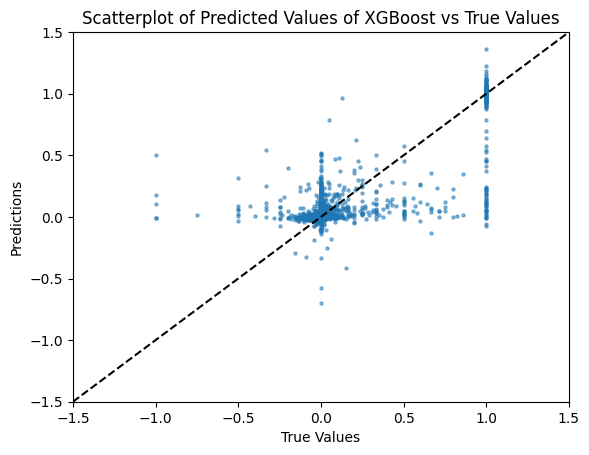

In [49]:
xgboost_model(x_train,y_train,x_test,y_test)

We see that there is a lot of variance, though the metrics are the following:


`Mean squared error: 0.01`


`R-squared score: 0.9635`

* Let's check if things change with an `MLP regressor`.

In [50]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


def mlp_model(x_train,y_train,x_test,y_test):
    # Create a MLPRegressor model with default hyperparameters
    mlp = MLPRegressor()
    
    # Fit the model to the training data
    mlp.fit(x_train, y_train)
    
    # Predict the target variable for the test data
    y_pred = mlp.predict(x_test)
    
    scatter_pred_true(y_test,y_pred,'MLP')

Mean squared error: 0.04
R-squared score: 0.8105


C:\Users\mernick\AppData\Local\Temp\ipykernel_28392\1593775445.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([-1.5, 1.5], [-1.5, 1.5], 'r--',color='black')


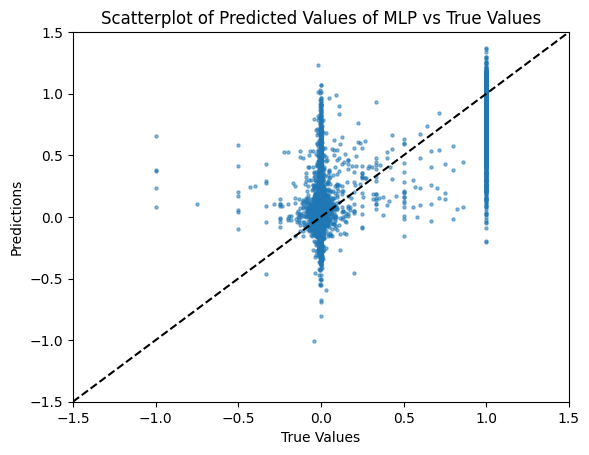

In [51]:
mlp_model(x_train,y_train,x_test,y_test)

Things get worse, both on the scatterplot and as far as the metrics are concerned.


`Mean squared error: 0.04`

`R-squared score: 0.8`

Finally, we implement a `Random Forest Regressor`.

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def randomForest_model(x_train,y_train,x_test,y_test):

    # Create random forest regression model and fit to training data
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(x_train, y_train)
    
    # Make predictions on test data
    y_pred = rf.predict(x_test)
    
    scatter_pred_true(y_test,y_pred,'Random Forest')

Mean squared error: 0.01
R-squared score: 0.9602


C:\Users\mernick\AppData\Local\Temp\ipykernel_28392\1593775445.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([-1.5, 1.5], [-1.5, 1.5], 'r--',color='black')


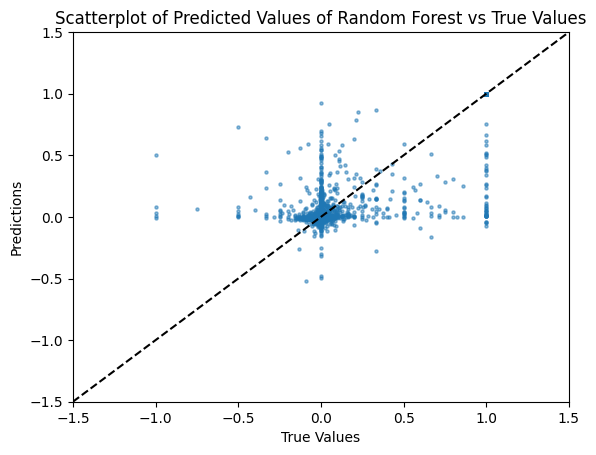

In [53]:
randomForest_model(x_train,y_train,x_test,y_test)

This model performs similarly as the `XGBoost`, both in terms of scatterplot and in the metrics.


`Mean squared error: 0.01`

`R-squared score: 0.9595446679572729`


###### Now, let's implement a neural network and predict.

First, we import the necessary libraries.

In [54]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers

import numpy as np
import random as rn
import os

(After a lot of attempts and fine tuning) We create the following a neural network.

#### The model has the following 5 layers:


* 1st: Dense with 128 neurons and a relu activation function.



* 2nd: Dropout, dropping 50% of the input to prevent overfitting.


* 3rd: Dense with 64 neurons and a relu activation function.


* 4th: Dropout, dropping 20% of the input to prevent overfitting.


* 5th: Dense with 1 neuron. This is the final layer and has only one neuron, since we want to predict the cdindex.




We will compile the model with the Adam optimizer and mean squared error loss function, since it is an accurate metric.


We also add an early stop to prevent overfitting.



We will train the model with 100 epochs and a batch size of 32.

In [55]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam


def neural_network(x_train,y_train,x_test,y_test,x_val, y_val):
    # Define the model architecture
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])
    
    # Compile the model with the Adam optimizer and mean squared error loss function
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
    
    # Train the model with 100 epochs and batch size of 32
    history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val),callbacks=[early_stop])
    
    # Plot the training and validation loss over epochs
    plot_loss(history)
    
    # Test the model on the test set
    test_loss= model.evaluate(x_test, y_test)
    
    # Print the test loss
    print('Test loss:', test_loss)
    
    
    y_pred = model.predict(x_test)
    
    scatter_pred_true(y_test,y_pred,'neural network')


Epoch 1/100
924/924 [==============================] - 2s 2ms/step - loss: 0.1326 - val_loss: 0.0738
Epoch 2/100
924/924 [==============================] - 1s 1ms/step - loss: 0.0718 - val_loss: 0.0504
Epoch 3/100
924/924 [==============================] - 1s 2ms/step - loss: 0.0539 - val_loss: 0.0431
Epoch 4/100
924/924 [==============================] - 1s 2ms/step - loss: 0.0455 - val_loss: 0.0373
Epoch 5/100
924/924 [==============================] - 1s 1ms/step - loss: 0.0408 - val_loss: 0.0353
Epoch 6/100
924/924 [==============================] - 1s 1ms/step - loss: 0.0374 - val_loss: 0.0323
Epoch 7/100
924/924 [==============================] - 1s 1ms/step - loss: 0.0361 - val_loss: 0.0313
Epoch 8/100
924/924 [==============================] - 1s 1ms/step - loss: 0.0338 - val_loss: 0.0310
Epoch 9/100
924/924 [==============================] - 1s 1ms/step - loss: 0.0327 - val_loss: 0.0294
Epoch 10/100
924/924 [==============================] - 1s 1ms/step - loss: 0.0311 - val_lo

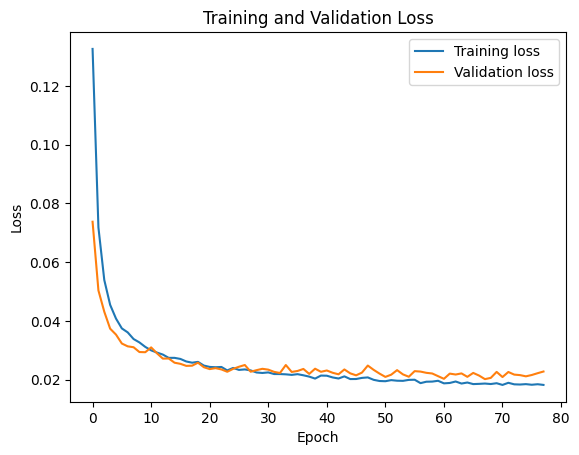

289/289 [==============================] - 0s 753us/step - loss: 0.0262
Test loss: 0.026182597503066063
289/289 [==============================] - 0s 687us/step
Mean squared error: 0.03
R-squared score: 0.8786


C:\Users\mernick\AppData\Local\Temp\ipykernel_28392\1593775445.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([-1.5, 1.5], [-1.5, 1.5], 'r--',color='black')


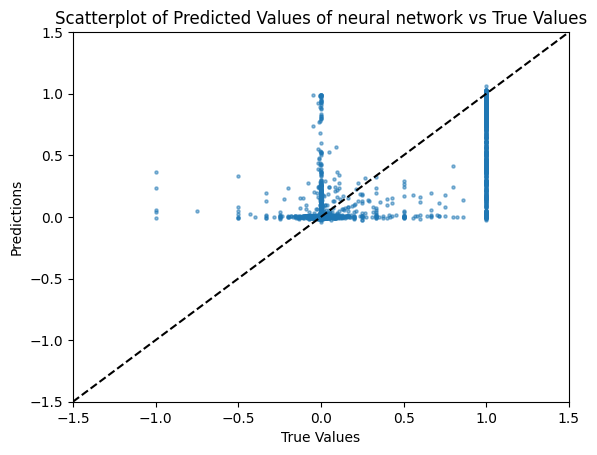

In [56]:
neural_network(x_train,y_train,x_test,y_test,x_val, y_val)

#### Loss function

* The loss function does not show signs of overfitting, since the loss for the training data continues to decrease along with the loss  for the validation data.


* We see, however, that there is not much change in as the epochs increase, so there is no need for so many epochs.

#### Metrics
The metrics are the following: 

`Mean squared error: 0.02`

`R-squared score: 0.9`

#### Scatterplot
The scatterplot shows a lot of variance. 


#### Maybe we need to change some features .


What if we remove the topics and the subjects from the `x` dataset and rerun the models?

In [57]:
x = x.loc[:,['published_year','count_of_subjects','number_of_authors','number_of_references']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

Our `x_train` looks like this now:

In [58]:
x_train.head()

,published_year,count_of_subjects,number_of_authors,number_of_references
36549,0.353258,-0.245210,1.439651,0.568311
26390,0.019595,0.507527,0.408230,0.068326
3480,-0.564314,1.260265,2.814880,0.104040
14030,1.020583,0.507527,-0.279384,-0.288806
29988,0.603505,-0.997948,1.783459,-0.003100


Let's rerun the models and compare.

Mean squared error: 0.01
R-squared score: 0.9586


C:\Users\mernick\AppData\Local\Temp\ipykernel_28392\1593775445.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([-1.5, 1.5], [-1.5, 1.5], 'r--',color='black')


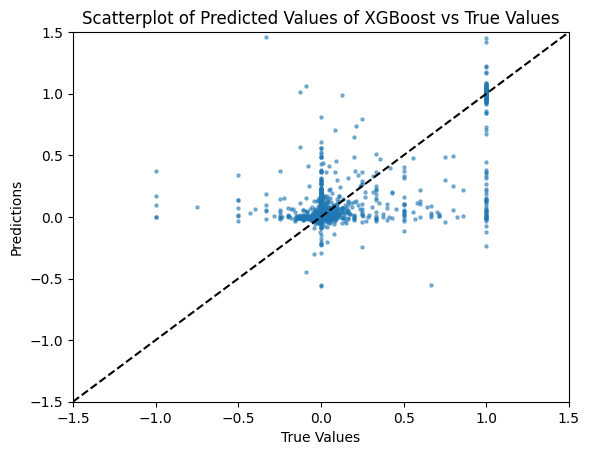

In [59]:
xgboost_model(x_train,y_train,x_test,y_test)


Mean squared error: 0.02
R-squared score: 0.8888


C:\Users\mernick\AppData\Local\Temp\ipykernel_28392\1593775445.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([-1.5, 1.5], [-1.5, 1.5], 'r--',color='black')


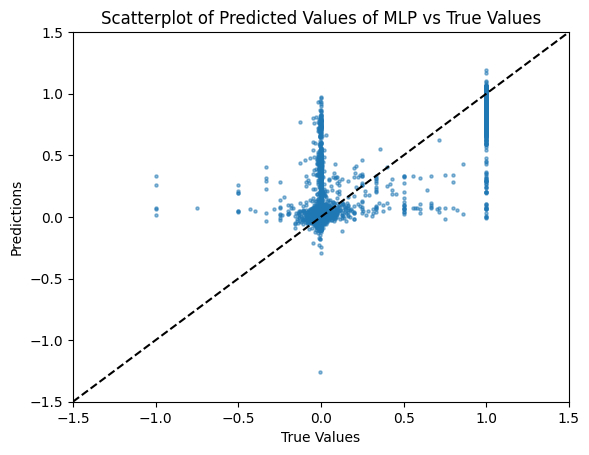

In [60]:
mlp_model(x_train,y_train,x_test,y_test)


Mean squared error: 0.01
R-squared score: 0.9565


C:\Users\mernick\AppData\Local\Temp\ipykernel_28392\1593775445.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([-1.5, 1.5], [-1.5, 1.5], 'r--',color='black')


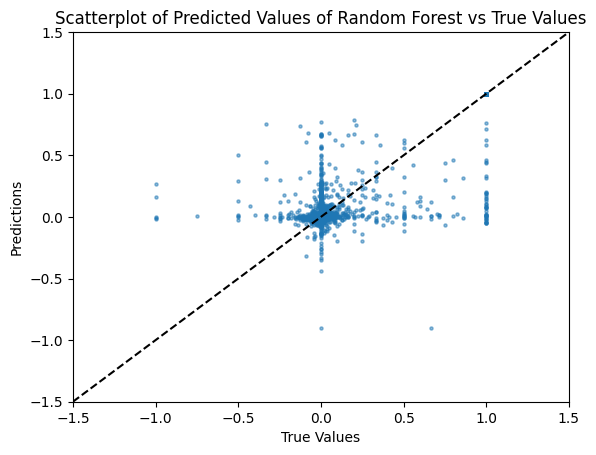

In [61]:
randomForest_model(x_train,y_train,x_test,y_test)


Epoch 1/100
924/924 [==============================] - 2s 1ms/step - loss: 0.1436 - val_loss: 0.0713
Epoch 2/100
924/924 [==============================] - 1s 1ms/step - loss: 0.0602 - val_loss: 0.0363
Epoch 3/100
924/924 [==============================] - 1s 1ms/step - loss: 0.0422 - val_loss: 0.0306
Epoch 4/100
924/924 [==============================] - 1s 1ms/step - loss: 0.0372 - val_loss: 0.0267
Epoch 5/100
924/924 [==============================] - 1s 1ms/step - loss: 0.0337 - val_loss: 0.0347
Epoch 6/100
924/924 [==============================] - 1s 1ms/step - loss: 0.0320 - val_loss: 0.0252
Epoch 7/100
924/924 [==============================] - 1s 1ms/step - loss: 0.0309 - val_loss: 0.0223
Epoch 8/100
924/924 [==============================] - 1s 1ms/step - loss: 0.0301 - val_loss: 0.0224
Epoch 9/100
924/924 [==============================] - 1s 1ms/step - loss: 0.0290 - val_loss: 0.0228
Epoch 10/100
924/924 [==============================] - 1s 1ms/step - loss: 0.0282 - val_lo

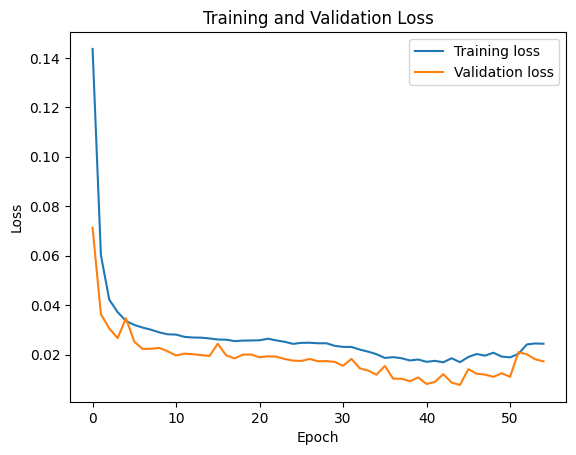

289/289 [==============================] - 0s 635us/step - loss: 0.0190
Test loss: 0.0189933143556118
289/289 [==============================] - 0s 580us/step
Mean squared error: 0.02
R-squared score: 0.912


C:\Users\mernick\AppData\Local\Temp\ipykernel_28392\1593775445.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([-1.5, 1.5], [-1.5, 1.5], 'r--',color='black')


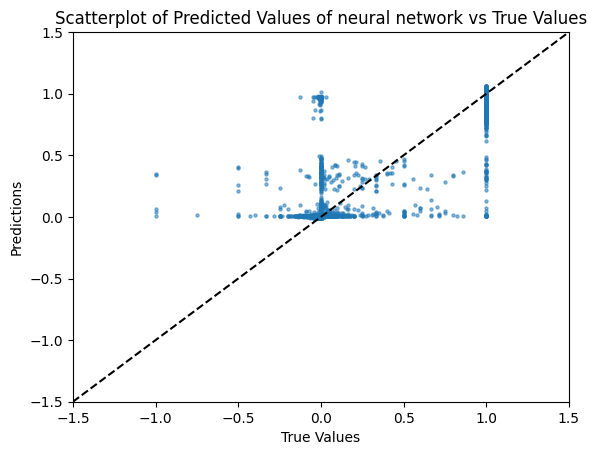

In [62]:
neural_network(x_train,y_train,x_test,y_test,x_val, y_val)

Overall, it seems that the difference with the two different sets of features is not huge.

#### These were all the models to predict the cdindex. 

While the attempts of the models above were successful to some extent, the imbalanced nature of the data still posed a significant challenge to the models.